# Minuit

Minuit è un package sviluppado da Fred James al CERN negli anni '70 in fortran, successivamente portato in C++, e recentemente disponibile in python.

È ancora insuperato per una serie di problemi di minimizzazione. Rispetto anche ad altri algoritmi di minimizzazione forniti in ```scipy.optimize``` continua ad essere preferibile per la gran parte dei problemi di fit che possono essere necessari in fisica.

La ricerca del minimo è fatta seguendo i gradiente della funzione intorno ad un insieme di **valori iniziali**. In caso più minimi siano presenti, in genere viene raggiunto quello più vicini ai valori inizali.

È disponibile un tutorial online in diverse parti all'<a href="https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/">interfaccia python ```iminuit```</a> sul quale sono basati gli esempi che seguono.

C'è anche una <a href="https://iminuit.readthedocs.io/en/stable/">documentazione ufficiale del modulo</a>.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math

Costruiamo una nostra funzione di likelihood, e minimizziamola. Consideriamo una PDF gaussiana con $\sigma$ nota, per semplicità.

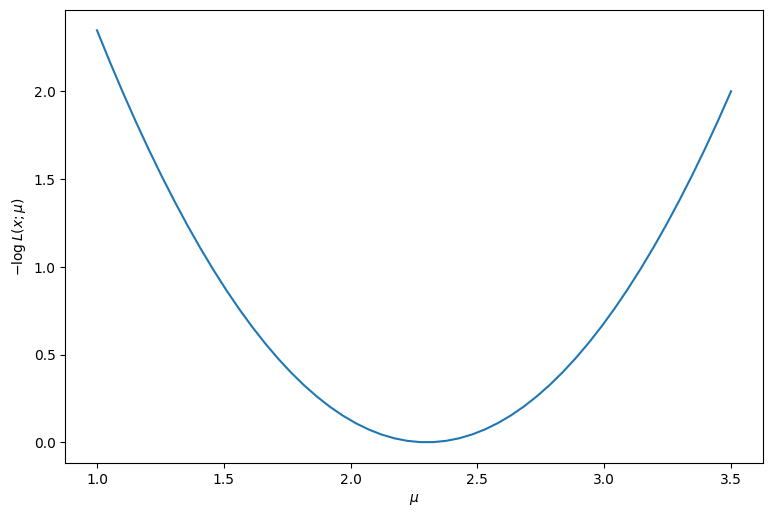

In [3]:
sigma = 0.6
sigma2 = sigma**2
two_sigma2=2*sigma2
x_obs = 2.3
def like_fun(mu):
    return (x_obs-mu)**2/two_sigma2
mus= np.linspace(1, 3.5)
plt.figure(figsize=(9,6), dpi=100)
plt.plot(mus, like_fun(mus))
plt.xlabel('$\mu$')
plt.ylabel('$-\log L(x;\mu)$')
plt.show()

La funzione ```like_fun``` può essere definita come $-\log{\cal{L}}$ oppure come $-2\log{\cal{L}}=\chi^2$. Nei due casi va moltiplicata per in fattore pari a $\frac{1}{2}$ o $1$, perché di default Minuit considera la minimmizzazzione di un $\chi^2$.

In [4]:
Minuit.LIKELIHOOD, Minuit.LEAST_SQUARES

(0.5, 1.0)

In [5]:
like_fun.errordef = Minuit.LIKELIHOOD 
mu0 = 1.0
minuit = Minuit(like_fun, mu=mu0)
minuit.migrad()
print("starting value {:.3f}, minimum at {:.3f}".format(mu0, minuit.values["mu"]))

starting value 1.000, minimum at 2.300


Da notare che si può usare sia ```minuit.values["mu"]``` (per nome) che ```minuit.values[0]``` (per indice).

In [6]:
print("error: {:.3f}".format(minuit.errors["mu"]))

error: 0.600


In [7]:
minuit.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.657e-19                  │              Nfcn = 18               │
│ EDM = 1.66e-19 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │    2.3    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────┐
│    │   mu │
├────┼──────┤
│ mu │ 0.36 │
└────┴──────┘

In [8]:
print("error: {:.3f}".format(minuit.errors["mu"]))

error: 0.600


In [9]:
for p in minuit.params:
    print(p.name, "= {:.3f} +/- {:.3f}".format(p.value, p.error))

mu = 2.300 +/- 0.600


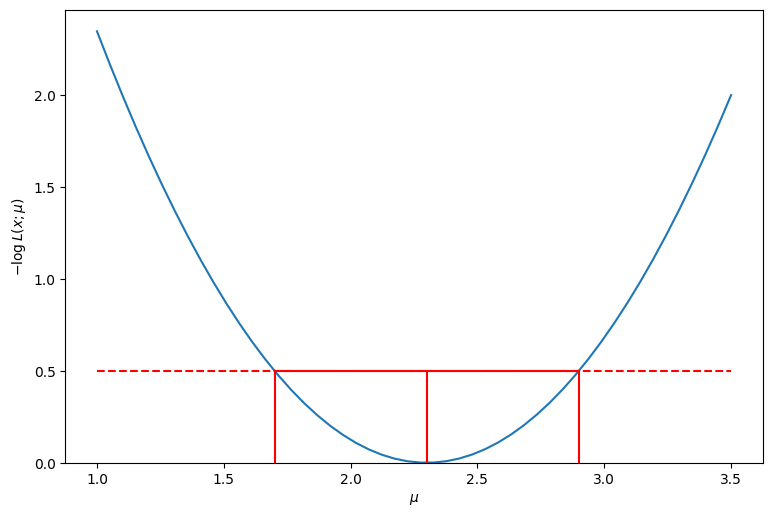

In [10]:
plt.figure(figsize=(9,6), dpi=100)
mus= np.linspace(1, 3.5)
plt.plot(mus, like_fun(mus))
plt.xlabel('$\mu$')
plt.ylabel('$-\log L(x;\mu)$')
mu_hat = minuit.values[0]
mu_err = minuit.errors[0]
plt.plot((mu_hat,mu_hat), (0, 0.5), color='r')
plt.plot((mu_hat-mu_err,mu_hat-mu_err), (0, 0.5), color='r')
plt.plot((mu_hat+mu_err,mu_hat+mu_err), (0, 0.5), color='r')
plt.plot((mu_hat-mu_err,mu_hat+mu_err), (0.5, 0.5), color='r')
plt.plot((mus[0],mus[-1]), (0.5, 0.5), color='r', linestyle='--')
plt.ylim(0)
plt.show()

## Regressione lineare
Implementiamo un fit lineare ai minimi quadrati usando ```Minuit```.

In [11]:
def line(x, a, b):
    return a * x + b

In [12]:
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # potremmo anche usare un vettore con errori differenti per ciascun punto
data_y = line(data_x, 2, 1) + data_yerr * np.random.normal(0, 1, len(data_x))

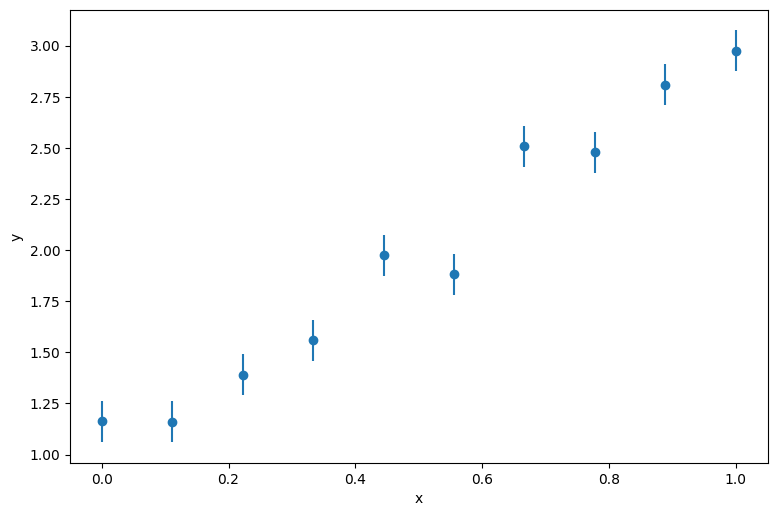

In [13]:
plt.figure(figsize=(9,6), dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Usiamo la funzione ```LeastSquares``` che ci fa risparemiare di definire il $\chi^2$.

In [14]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)
m = Minuit(least_squares, a=0, b=0)
m.migrad()  # ricerca del minimo
m.hesse()   # calcolo accurato delle incertezze

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │              Nfcn = 46               │
│ EDM = 1.33e-20 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.97    │   0.10    │            │            │         │         │       │
│ 1 │ b    │   1.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │  0.00982 -0.00491 │
│ b │ -0.00491  0.00345 │
└───┴───────────────────┘

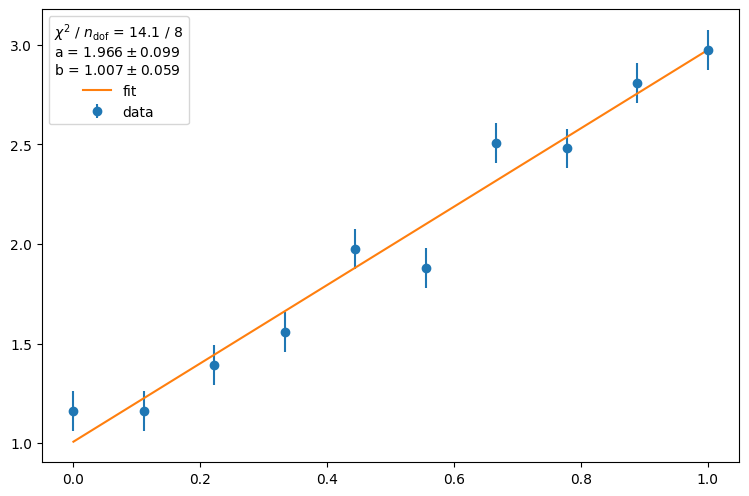

In [15]:
plt.figure(figsize=(9,6), dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")
fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
plt.legend(title="\n".join(fit_info))
plt.show()

Proviamo ora un fit polinomiale.

In [16]:
def line_np(x, par):
    return np.polyval(par, x)

In [17]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

In [18]:
Minuit(least_squares_np, (5, 5))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


Di defaut i nomi dei parametri sono ```x0```, ```x1```, ..., ma possono essere cambiati esplicitandoli.

In [19]:
Minuit(least_squares_np, (5, 5), name=("a", "b"))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


In [20]:
m = Minuit(least_squares_np, (5, 5, 5), name=("a", "b", "c"))

In [21]:
m.migrad()
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.85                      │              Nfcn = 68               │
│ EDM = 7.97e-18 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.39    │   0.35    │            │            │         │         │       │
│ 1 │ b    │    1.6    │    0.4    │            │            │         │         │       │
│ 2 │ c    │   1.06    │   0.08    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │   0.124  -0.124  0.0184 │
│ b │  -0.124   0.134 -0.0233 │
│ c │  0.0184 -0.0233 0.00618 │
└───┴─────────────────────────┘

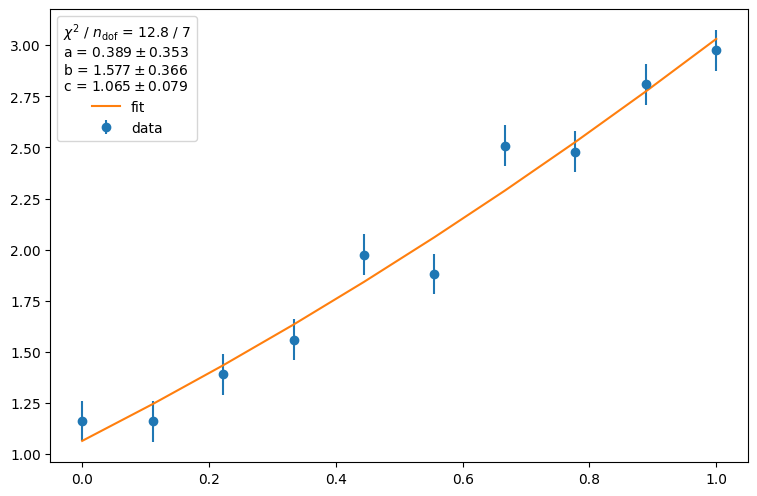

In [22]:
plt.figure(figsize=(9,6), dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line_np(data_x, m.values), label="fit")
fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
plt.legend(title="\n".join(fit_info))
plt.show()

Ispezione dei parametri

In [23]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.39,0.35,,,,,
1,b,1.6,0.4,,,,,
2,c,1.06,0.08,,,,,


In [24]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='a', value=0.3891310199298852, error=0.35250423485417015, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None) 

Param(number=1, name='b', value=1.5769054131029918, error=0.3661655042462983, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None) 

Param(number=2, name='c', value=1.0649167343758277, error=0.07862410208041858, merror=None, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None) 



In [25]:
for p in m.params:
    print(p.name, "= {:.3f} +/- {:.3f}".format(p.value, p.error))

a = 0.389 +/- 0.353
b = 1.577 +/- 0.366
c = 1.065 +/- 0.079


(array([-0.31587745, -0.30163485, -0.28739226, -0.27314966, -0.25890707,
        -0.24466447, -0.23042188, -0.21617928, -0.20193669, -0.18769409,
        -0.1734515 , -0.1592089 , -0.14496631, -0.13072371, -0.11648111,
        -0.10223852, -0.08799592, -0.07375333, -0.05951073, -0.04526814,
        -0.03102554, -0.01678295, -0.00254035,  0.01170224,  0.02594484,
         0.04018743,  0.05443003,  0.06867262,  0.08291522,  0.09715782,
         0.11140041,  0.12564301,  0.1398856 ,  0.1541282 ,  0.16837079,
         0.18261339,  0.19685598,  0.21109858,  0.22534117,  0.23958377,
         0.25382636,  0.26806896,  0.28231155,  0.29655415,  0.31079675,
         0.32503934,  0.33928194,  0.35352453,  0.36776713,  0.38200972,
         0.39625232,  0.41049491,  0.42473751,  0.4389801 ,  0.4532227 ,
         0.46746529,  0.48170789,  0.49595049,  0.51019308,  0.52443568,
         0.53867827,  0.55292087,  0.56716346,  0.58140606,  0.59564865,
         0.60989125,  0.62413384,  0.63837644,  0.6

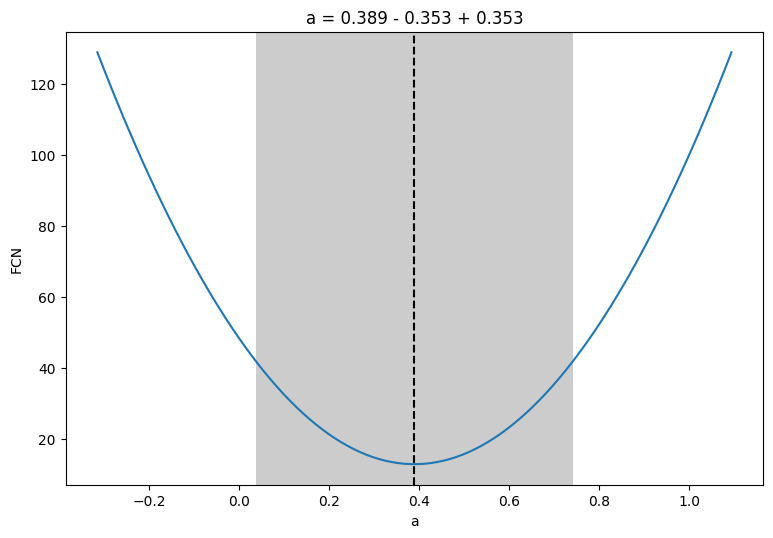

In [27]:
plt.figure(figsize=(9,6), dpi=100)
m.draw_profile("a")

(array([0.8445744 , 0.85936897, 0.87416354, 0.8889581 , 0.90375267,
        0.91854723, 0.9333418 , 0.94813637, 0.96293093, 0.9777255 ,
        0.99252006, 1.00731463, 1.02210919, 1.03690376, 1.05169833,
        1.06649289, 1.08128746, 1.09608202, 1.11087659, 1.12567116,
        1.14046572, 1.15526029, 1.17005485, 1.18484942, 1.19964398,
        1.21443855, 1.22923312, 1.24402768, 1.25882225, 1.27361681,
        1.28841138, 1.30320595, 1.31800051, 1.33279508, 1.34758964,
        1.36238421, 1.37717877, 1.39197334, 1.40676791, 1.42156247,
        1.43635704, 1.4511516 , 1.46594617, 1.48074074, 1.4955353 ,
        1.51032987, 1.52512443, 1.539919  , 1.55471356, 1.56950813,
        1.5843027 , 1.59909726, 1.61389183, 1.62868639, 1.64348096,
        1.65827553, 1.67307009, 1.68786466, 1.70265922, 1.71745379,
        1.73224835, 1.74704292, 1.76183749, 1.77663205, 1.79142662,
        1.80622118, 1.82101575, 1.83581032, 1.85060488, 1.86539945,
        1.88019401, 1.89498858, 1.90978314, 1.92

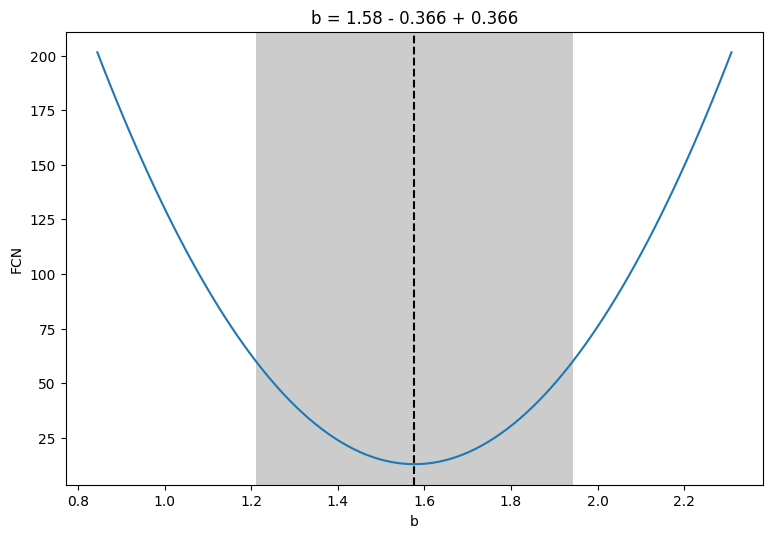

In [28]:
plt.figure(figsize=(9,6), dpi=100)
m.draw_profile("b")

In [29]:
m.covariance

,a,b,c
a,0.124,-0.124 (-0.963),0.0184 (0.664)
b,-0.124 (-0.963),0.134,-0.0233 (-0.810)
c,0.0184 (0.664),-0.0233 (-0.810),0.00618


In [30]:
print("err(a) = {:.3f}".format(math.sqrt(m.covariance[0,0])))
print("err(b) = {:.3f}".format(math.sqrt(m.covariance[1,1])))
print("err(c) = {:.3f}".format(math.sqrt(m.covariance[2,2])))
print("cov(a,b) = {:.3f}".format(m.covariance[0,1]))
print("cov(a,c) = {:.3f}".format(m.covariance[0,2]))
print("cov(b,b) = {:.3f}".format(m.covariance[1,2]))

err(a) = 0.353
err(b) = 0.366
err(c) = 0.079
cov(a,b) = -0.124
cov(a,c) = 0.018
cov(b,b) = -0.023


In [31]:
m.covariance.correlation()

,a,b,c
a,1,-0.963,0.664
b,-0.963,1,-0.81
c,0.664,-0.81,1


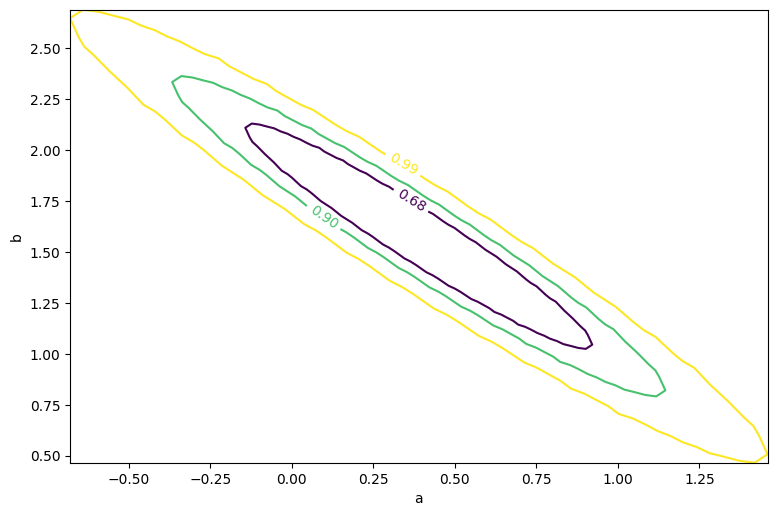

In [32]:
plt.figure(figsize=(9,6), dpi=100)
m.draw_mncontour("a", "b", cl=(0.68, 0.9, 0.99))

<a list of 4 text.Text objects>

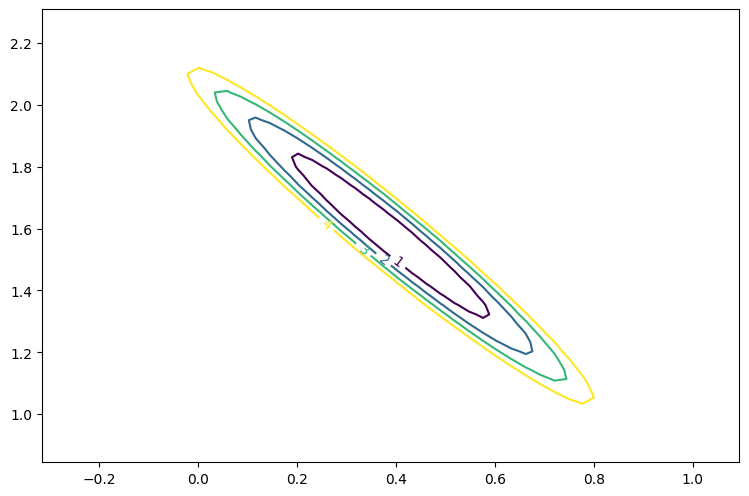

In [33]:
plt.figure(figsize=(9,6), dpi=100)
x, y, z = m.contour("a", "b", subtract_min=True)
cs = plt.contour(x, y, z, (1, 2, 3, 4))
plt.clabel(cs)

I parametri possono essere costretti entro limiti espliciti.

In [34]:
m.limits = [(0, None), (0, 10), (0, 4)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.39,0.35,,,0,,
1,b,1.6,0.4,,,0,10,
2,c,1.06,0.08,,,0,4,


Si può fissare il valore di uno o più parametri.

In [35]:
m.values["a"] = 0
m.fixed["a"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.00,0.35,,,0,,yes
1,b,1.6,0.4,,,0,10,
2,c,1.06,0.08,,,0,4,


In [36]:
m.migrad()
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │             Nfcn = 9850              │
│ EDM = 2.16e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.00    │   0.35    │            │            │    0    │         │  yes  │
│ 1 │ b    │   1.97    │   0.10    │            │            │    0    │   10    │       │
│ 2 │ c    │   1.01    │   0.06    │            │            │    0    │    4    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │        0        0        0 │
│ b │        0  0.00982 -0.00491 │
│ c │        0 -0.00491  0.00345 │
└───┴────────────────────────────┘

## Funzioni con più minimi


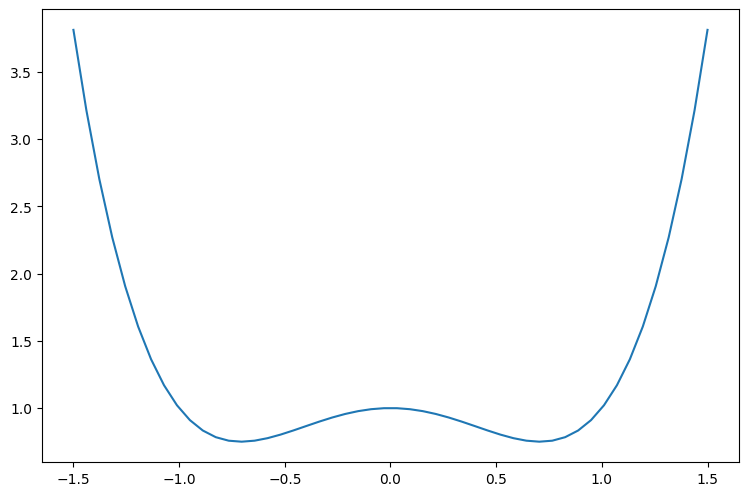

In [37]:
def f2min(x):
    return x ** 4 - x ** 2 + 1

# tratta la funzione come Chi^2 anziché come Likelihood
f2min.errordef = Minuit.LEAST_SQUARES 

plt.figure(figsize=(9,6), dpi=100)
x = np.linspace(-1.5, 1.5)
plt.plot(x, f2min(x))

In [38]:
m = Minuit(f2min, x=-0.1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975


In [39]:
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value +0.1, minimum at 0.708796091342642


# Fit di una funzione generica

In [40]:
def fit_model(x,par):
    return par[0]*(1.0-np.exp(-par[1]*x))
a_true = 50
b_true = 0.3
data_x = np.arange(1, 20.5, 1)
data_y0 = fit_model(data_x, (a_true, b_true))
data_yerr = np.sqrt(data_y0)
data_y = data_y0 + data_yerr * np.random.normal(0,1,len(data_x))

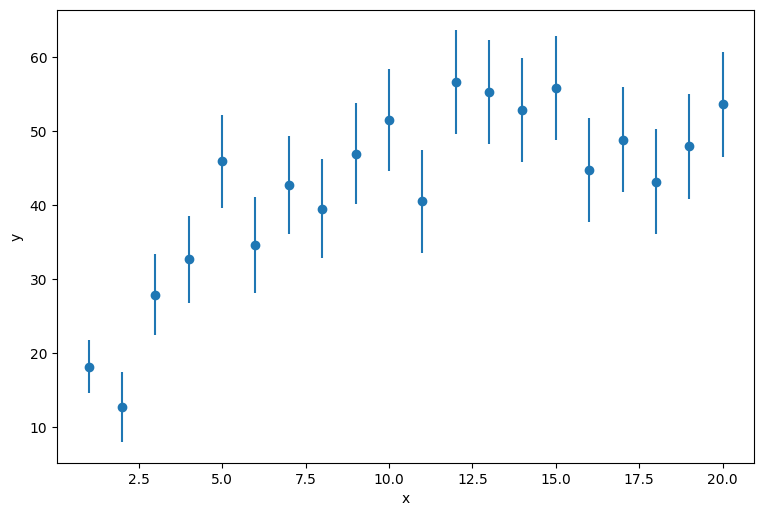

In [41]:
plt.figure(figsize=(9,6), dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Nota: quello che in Minuit viene chiamato ```LeastSquares``` in realtà un modello di $\chi^2$ perché è possibile passare errori che siano diversi tra loro.

In [42]:
least_squares_mode = LeastSquares(data_x, data_y, data_yerr, fit_model)
m = Minuit(least_squares_mode, (50,0.3), name=("a", "b"))
m.migrad()
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 15.91                      │              Nfcn = 47               │
│ EDM = 2.13e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   50.8    │    2.5    │            │            │         │         │       │
│ 1 │ b    │   0.27    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │    6.36  -0.083 │
│ b │  -0.083 0.00208 │
└───┴─────────────────┘

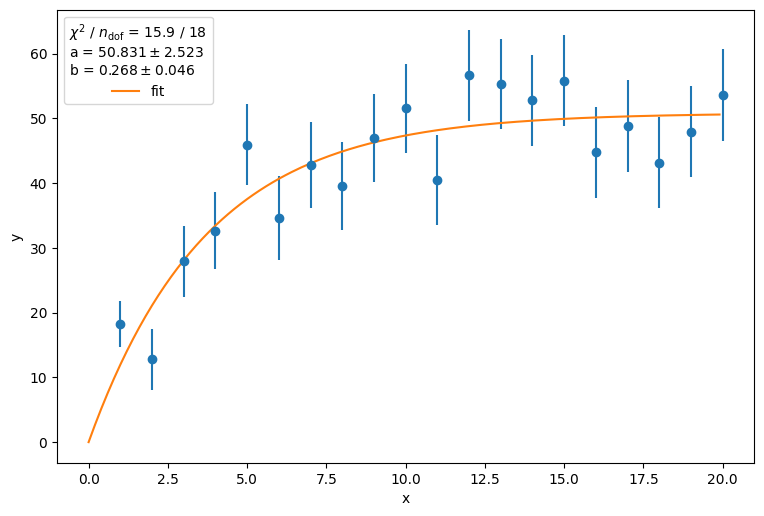

In [43]:
plt.figure(figsize=(9,6), dpi=100)
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
data_x_f = np.arange(0, 20, 0.1)
data_y_f = fit_model(data_x_f, m.values)
plt.plot(data_x_f, data_y_f, label="fit")
plt.xlabel('x')
plt.ylabel('y')
fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
plt.legend(title="\n".join(fit_info))
plt.show()

## Valori inziali

Con gli esempi che abbiamo visto, simulati, *sappiamo* qual è il valore *vero*, ossia quello che abbiamo usato per generare i campioni di dati che abbiamo usato per il fit.

Quando abbiamo campioni di dati veri *non conosciamo* i valori veri. Bisogna quindi provare valori iniziali diversi da stime approssimate. Non è ovvio che il fit convergerà.

Esistono diverse pratiche usate per trovare i valori iniziali, che potranno essere provate in vari esempi. Come prima cosa, si possono determinare in prima approssimazione alcuni parametri in base ad alcunce caratteristiche. Esempio:
* dove si trova un asintoto (e quindi come questo si riflette nella scelta di uno o più parametri)
* dove si trova un picco e quanto è largo
* quanto vale, approssimativamente, la pendenza di un andamento in approssimazione lineare o esponenziale

Una possibilità è fare il fit di una regione limitata del campione e determinare alcuni parametri che saranno poi usati come valori iniziali.

A volte conviene fissare alcuni parametri, determinarne alcuni, e, solo come ultimo passo, si possono determinare tutti i valori.

Inevitabilmente l'esperienza sarà un fattore importrante per trovare in modo rapido la migliore startegia per i casi pià complicati.

# Spunti per esercizi

* Per effettuare una misura ripetuta di effcienza, si contano $N$ raggi cosmici con un sistema di scintillatori che attraversano un rivelatore, e di questi $n$ danno un segnale nel rivelatore. Stimare l'efficienza $\varepsilon$ del rivelatore con la seguente tabella di valori misurati:

In [45]:
data = np.array([[50, 49], [60, 58], [40, 40], [52, 51], [56, 56], [69, 67], [55, 52]])

*hint*: si consideri la funzione di verosimiglianza data dal prodotto di $k$ bionomiali.

* Fit di una funzione esponenziale su un *istogramma* ottenuto generando una sequenza di valori generati secondo una distribuzione esponenziale con parametro $\lambda$ ignoto.

* Fit di una funzione gaussiana del tipo: $a \exp(-(x-b)/2c^2)$ su un istogramma ottenuto generando il contenuto in modo pseudocasuale.

* Fit di una funzione esponenziale del tipo: $a\,x^{b}\,e^{-c\, x}$ con dati generati in maniera pseudocasuale. $c$ deve essere positivo.